In [1]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from io import StringIO

/home/paolo/.conda/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
# Read the file
with open('./Rankings/cos.txt', 'r') as f:
    lines = f.readlines()

# Remove comment line (starts with '#')
lines = [line for line in lines if not line.strip().startswith('#')]

# Join the cleaned lines into a single string
data = ''.join(lines)

# Use pandas to read from the cleaned string
df = pd.read_csv(StringIO(data), sep=r'\s{2,}', engine='python', header=None)
df.columns = ['FEAT_ID', 'Score', 'Feature Expression']

print(df)

   FEAT_ID     Score  Feature Expression
0        0  0.705902  (sin(f1) + (f1^2))
1        1  0.793289         (sin(f1)^2)
2        2  0.857926          ((f1^2)^2)
3        3  0.950380         cos((f1^2))
4        4  0.976459  (cos(f1) + (f1^2))
5        5  0.976489      (sin(f1) * f1)
6        6  0.990621              (f1^2)
7        7  0.995005  (cos(f1) - (f1^2))
8        8  0.998180      (sin(f1) / f1)
9        9  1.000000             cos(f1)


In [12]:
x = sp.symbols('f1')
symbol_map = {'x': x}
formulas = df['Feature Expression'][[9]]

# Converts the equtions from strings into sympy objects
sympy_exprs = [sp.sympify(f, locals=symbol_map) for f in formulas]
# Convert the expressions into functions
functions = [sp.lambdify((x), expr, modules='numpy') for expr in sympy_exprs]

In [13]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [14]:
n_samples = 300
x_train = np.linspace(-2, 2, n_samples)
Phi = np.column_stack([f(x_train) for f in functions])

n_features = Phi.shape[1]

y = np.cos(x_train)

In [18]:
Phi.shape

(300, 1)

In [15]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    w = pm.Normal("w", mu=0, sigma=10, shape=n_features)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome, Linear model
    mu = pm.math.dot(Phi, w)

    # Likelihood (sampling distribution) of observations --> normal distribution with the deterministic equation as mean and sigma as variance
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

In [16]:
with basic_model:
    # To change the sampling method, NUTS should be the default
    #step = pm.Metropolis()
    # draw 1000 posterior samples from the unnormalized posterior distribution computed as likelihood x prior
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 452 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


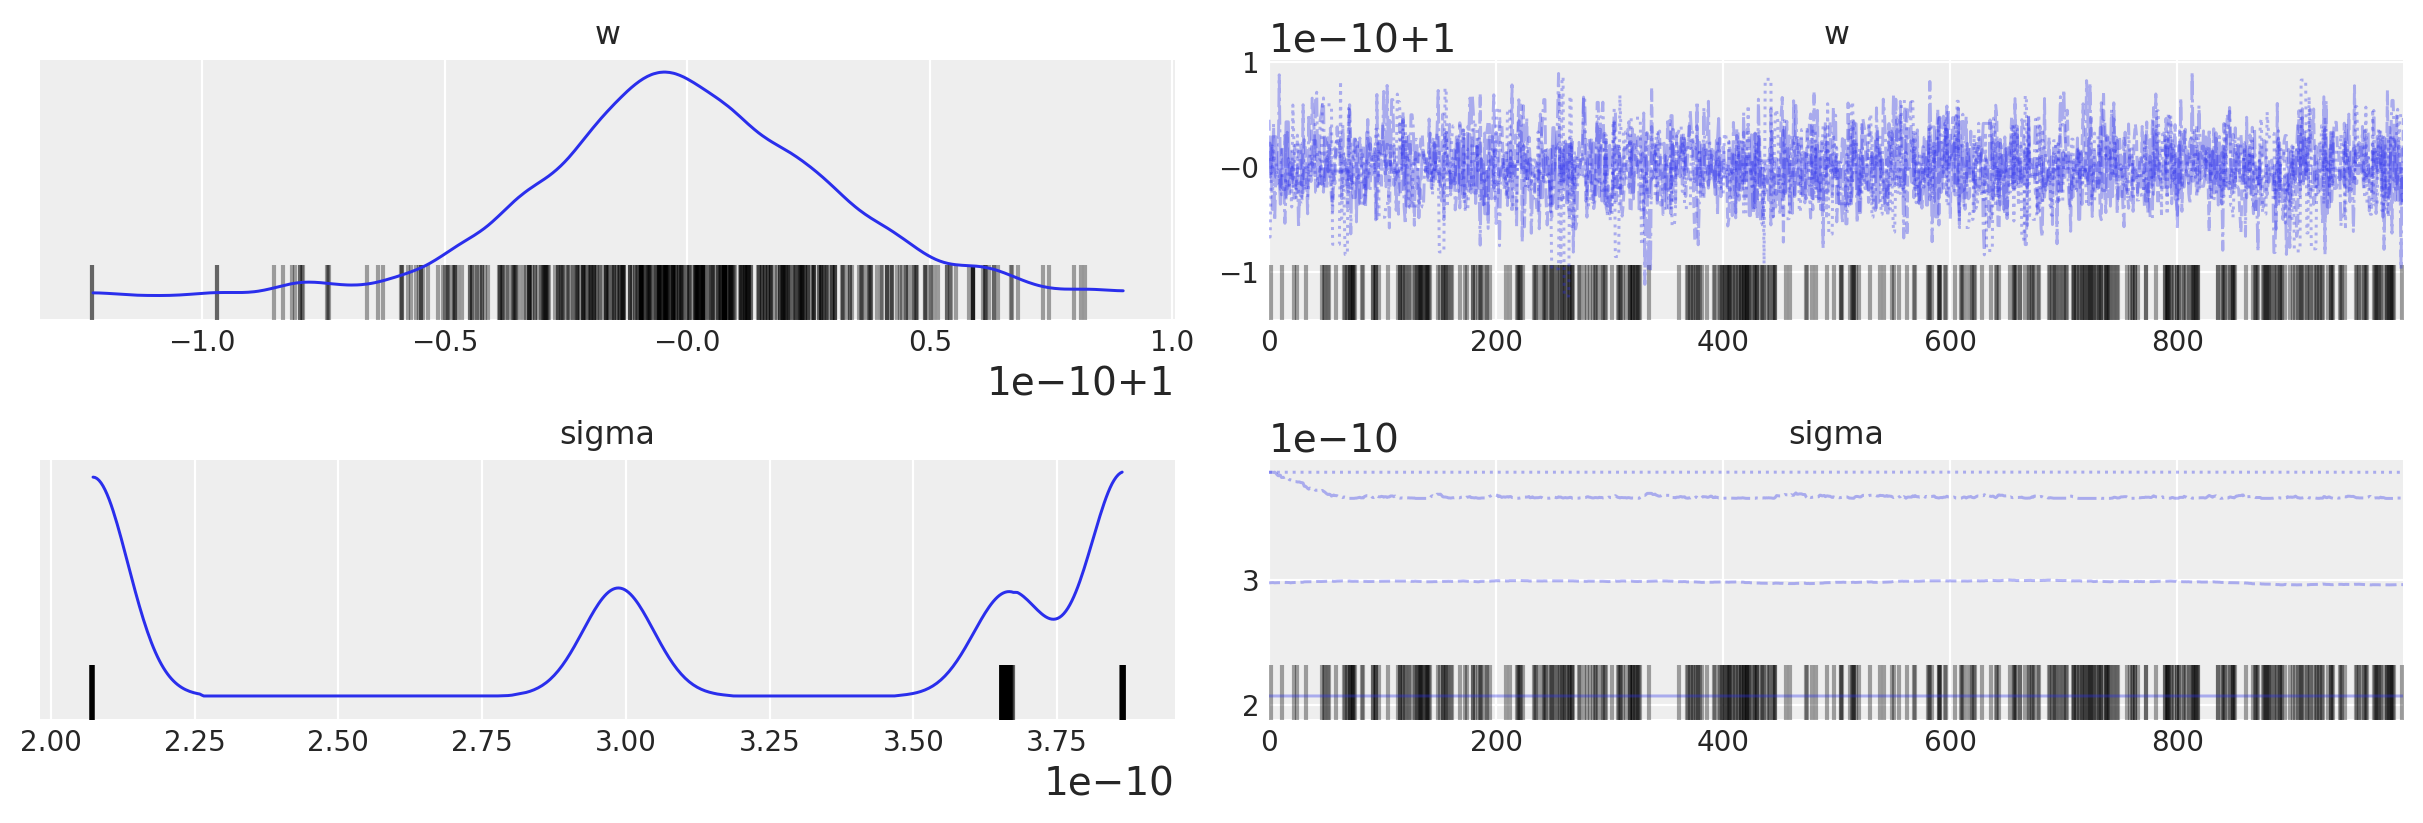

In [19]:
az.plot_trace(idata, combined=True);

In [9]:
# Predictive data
x_test = np.linspace(-5, 5, 300)
Phi_test = np.column_stack([f(x_test) for f in functions])

# Get posterior samples of weights and sigma 
posterior_w = idata.posterior["w"].stack(draws=("chain", "draw")).values  # (n_features, n_draws)
posterior_sigma = idata.posterior["sigma"].stack(draws=("chain", "draw")).values  # (n_draws,)

# Compute predictions
y_preds = posterior_w.T @ Phi_test.T  # shape: (n_draws, n_test)
y_mean = y_preds.mean(axis=0)
y_std = y_preds.std(axis=0)

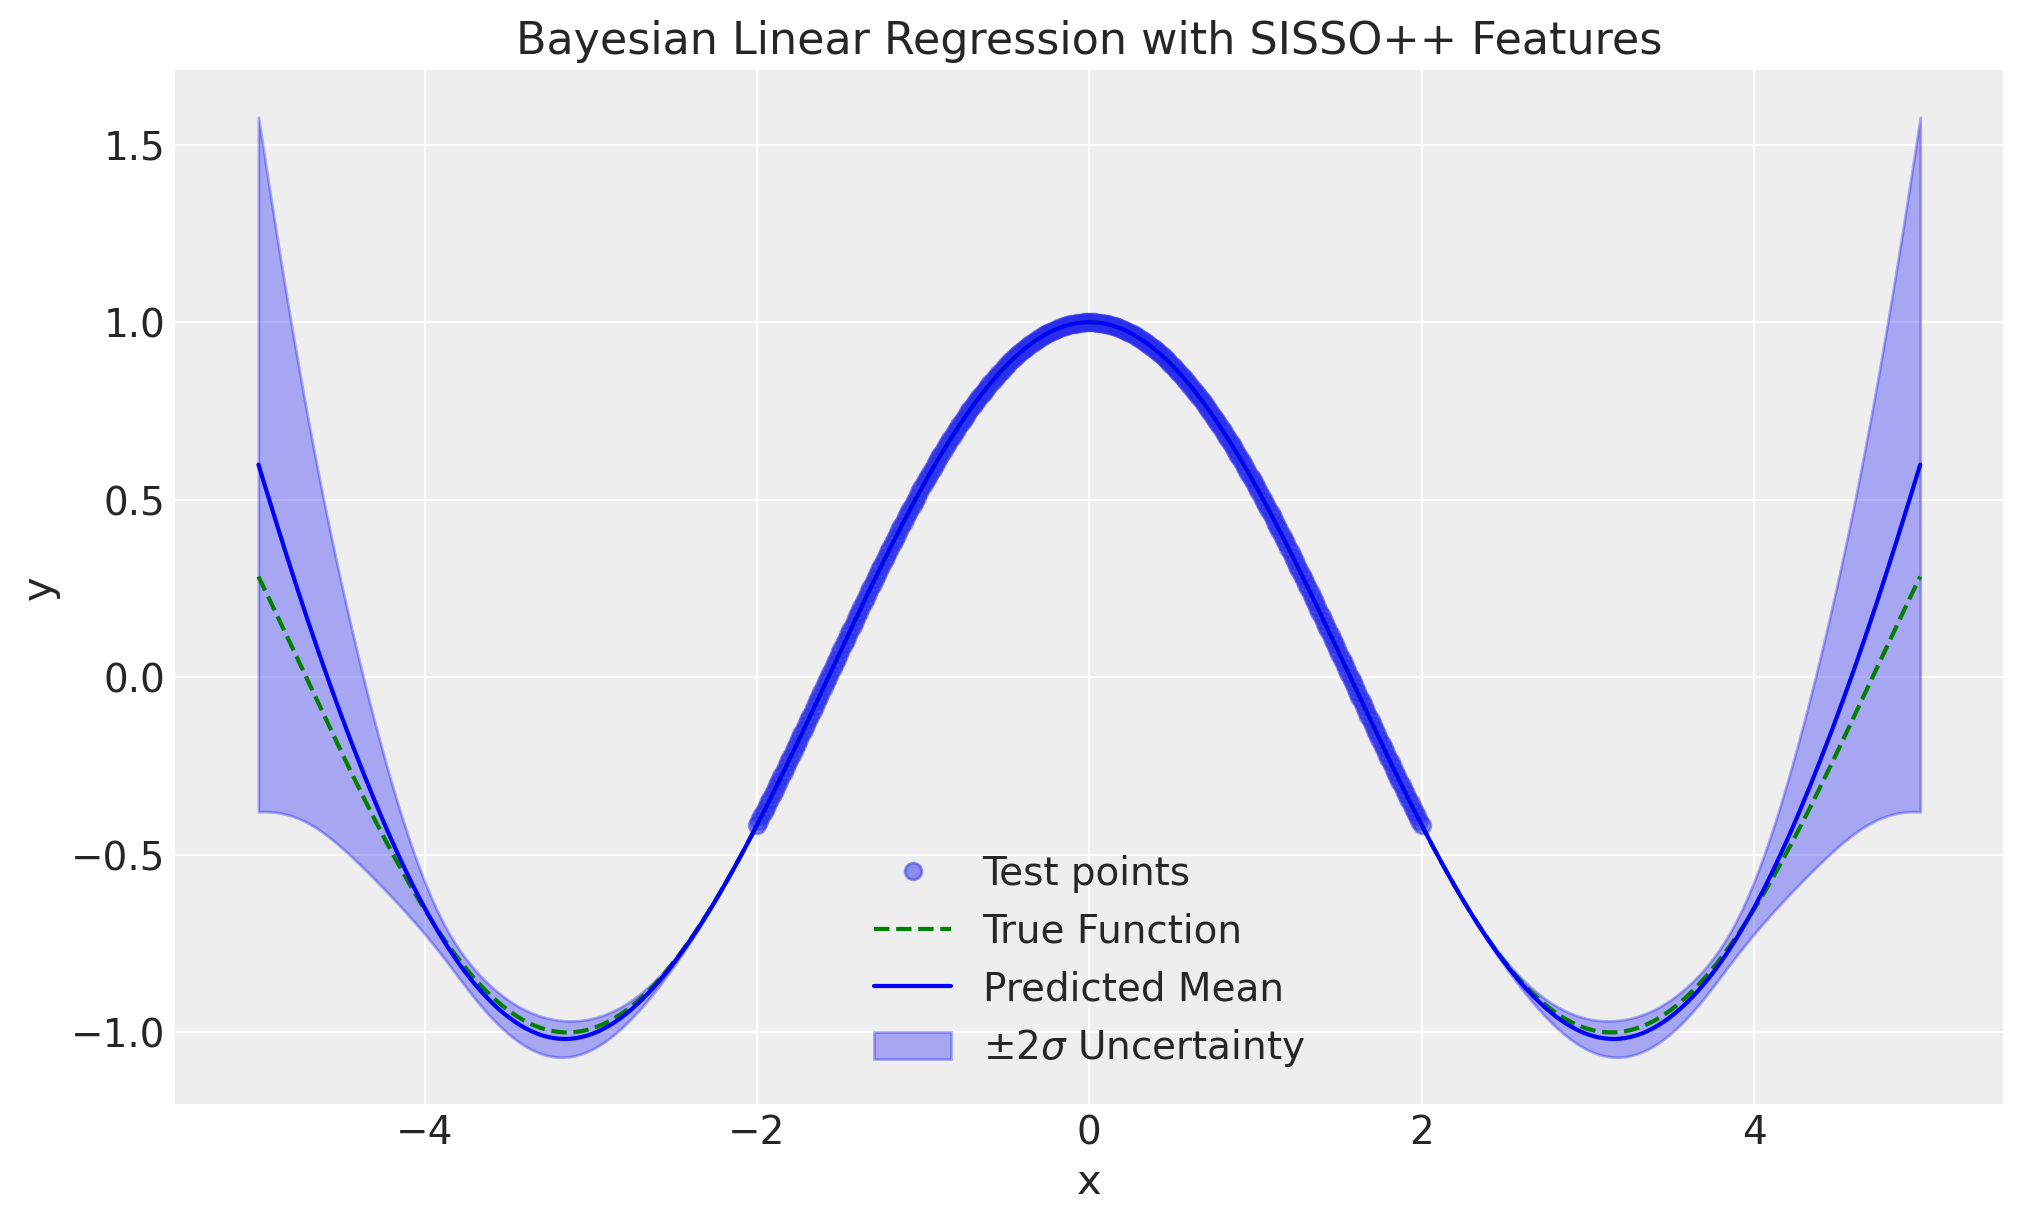

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(x_train, y, "o", label="Test points", alpha=0.5)
plt.plot(x_test, np.cos(x_test), label="True Function", color="green", linestyle="--")
plt.plot(x_test, y_mean, label="Predicted Mean", color="blue")
# 95% credibility interval standing in between y_mean - 2*std and y_mean + 2*std
plt.fill_between(x_test, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.3, color="blue", label=r"±2$\sigma$ Uncertainty")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Bayesian Linear Regression with SISSO++ Features")
plt.grid(True)
plt.show()